In [1]:
pip install pandas numpy scikit-learn openpyxl tqdm nltk

In [2]:
!pip install imbalanced-learn

In [3]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Custom Stopwords ---
custom_stopwords = set([
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "has", "he",
    "in", "is", "it", "its", "of", "on", "that", "the", "to", "was", "were", "will", "with"
])

custom_stopwords.update(["business", "variety", "range","company", "product", "reliable", "include", "make", "small", "two", "specialize", "including", "ensure", "company based", "day", "part", "become", "project", "goal", "client", "best", "type", "aim", "solution", "create", "using"])

# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = re.findall(r'\b\w+\b', text)
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(w) for w in tokens if w not in custom_stopwords]
    return ' '.join(tokens)

# Evaluation Function
def evaluate_with_manual_labels(companies_df, path="manual_labels.xlsx"):
    try:
        manual_df = pd.read_excel(path)
        manual_df['manual_label'] = manual_df['manual_label'].apply(eval)
        eval_df = companies_df[['pseudo_label', 'label_scores']].reset_index().merge(
            manual_df, left_on='index', right_on='id', how='inner'
        )

        total = len(eval_df)
        exact_matches = 0
        partial_over_50 = 0
        partial_under_50 = 0
        no_match = 0

        for pred, true, scores in zip(eval_df['pseudo_label'], eval_df['manual_label'], eval_df['label_scores']):
            pred_set = set(pred)
            true_set = set(true)

            # Calculate overlap considering confidence scores
            overlap = len(pred_set & true_set)
            total_pred = len(pred_set)
            total_true = len(true_set)

            if pred_set == true_set:
                exact_matches += 1
            elif overlap > 0:
                # Calculate weighted overlap based on confidence scores
                weighted_overlap = sum(score for label, score in zip(pred, scores) if label in true_set)
                weighted_total = sum(scores)

                if weighted_overlap / weighted_total >= 0.5:
                    partial_over_50 += 1
                else:
                    partial_under_50 += 1
            else:
                no_match += 1

        print(f"\n--- Enhanced Pseudo Evaluation Report ---")
        print(f"Total manually labeled samples: {total}")
        print(f"Exact matches: {exact_matches} ({exact_matches / total:.2%})")
        print(f"Partial matches (>50% correct): {partial_over_50} ({partial_over_50 / total:.2%})")
        print(f"Partial matches (<50% correct): {partial_under_50} ({partial_under_50 / total:.2%})")
        print(f"No match: {no_match} ({no_match / total:.2%})")

    except Exception as e:
        print(f"⚠️ Skipping manual evaluation. Reason: {e}")

# Load data
companies_df = pd.read_excel("ml_insurance_challenge.xlsx")
taxonomy_df = pd.read_excel("insurance_taxonomy.xlsx")

# Preprocess texts
companies_df['merged_text'] = companies_df[['description', 'sector', 'category', 'niche']].fillna('').agg(' '.join, axis=1)
companies_df['processed'] = companies_df['merged_text'].apply(preprocess_text)
taxonomy_df['processed_label'] = taxonomy_df['label'].astype(str).apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,3), max_df=0.9, smooth_idf=True)
label_vectors = vectorizer.fit_transform(taxonomy_df['processed_label'])
company_vectors = vectorizer.transform(companies_df['processed'])


from sklearn.preprocessing import normalize
company_vectors = normalize(company_vectors)
label_vectors = normalize(label_vectors)
# Similarity Matching
similarity_matrix = cosine_similarity(company_vectors, label_vectors)

# Assign Labels
initial_threshold = 0.2
min_threshold = 0.1
step = 0.05

def assign_labels_with_adaptive_threshold(similarity_row, taxonomy_df, initial_threshold=0.25, min_threshold=0.10):
    # Sort similarities in descending order
    sorted_indices = np.argsort(similarity_row)[::-1]
    sorted_similarities = similarity_row[sorted_indices]

    # Initialize variables
    threshold = initial_threshold
    labels = []
    scores = []

    # Try different thresholds
    while threshold >= min_threshold:
        # Get labels above current threshold
        current_labels = taxonomy_df['label'].iloc[sorted_indices[sorted_similarities >= threshold]].tolist()
        current_scores = sorted_similarities[sorted_similarities >= threshold].tolist()

        if current_labels:
            if len(current_labels) >= 1 and current_scores[0] >= threshold + 0.1:
                labels = current_labels
                scores = current_scores
                break

        threshold -= 0.05

    # If no labels found, use the top label with highest similarity
    if not labels:
        top_similarity = sorted_similarities[0]
        if top_similarity > 0.1:  # Minimum similarity threshold
            labels = [taxonomy_df['label'].iloc[sorted_indices[0]]]
            scores = [top_similarity]
        else:
            labels = ["Other"]
            scores = [1.0]

    return labels, scores

print("Assigning labels with adaptive thresholding...")
assigned_labels = []
assigned_scores = []

for sim in tqdm(similarity_matrix, desc="Assigning labels"):
    labels, scores = assign_labels_with_adaptive_threshold(sim, taxonomy_df)
    assigned_labels.append(labels)
    assigned_scores.append(scores)

companies_df['pseudo_label'] = assigned_labels
companies_df['label_scores'] = assigned_scores

# Run evaluation
evaluate_with_manual_labels(companies_df)

# Pseudo-supervised ML training
print("\nTraining supervised model on pseudo-labels...")
mlb = MultiLabelBinarizer()
y_full = mlb.fit_transform(companies_df['pseudo_label'])
X_full = vectorizer.transform(companies_df['processed'])

# Filter classes with sufficient frequency in order to improve model robustness
min_class_occurrence = 30
class_counts = y_full.sum(axis=0)
valid_classes = [i for i, count in enumerate(class_counts) if count >= min_class_occurrence]

# Reduce dataset to frequent classes only
y_filtered = y_full[:, valid_classes]
class_names_filtered = [mlb.classes_[i] for i in valid_classes]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_filtered, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(
    solver='liblinear', C=1.0, max_iter=1000, class_weight='balanced'
))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\n-- Supervised Model Evaluation --")
print(classification_report(y_test, y_pred, target_names=class_names_filtered, zero_division=0))

def fallback_cosine_label(text, threshold=0.4):
    processed = preprocess_text(text)
    vec = vectorizer.transform([processed])
    sims = cosine_similarity(vec, label_vectors)[0]

    if sims.max() < threshold:
        return ["Other"]
    return [taxonomy_df['label'][sims.argmax()]]

def predict_with_confidence(text, threshold=0.3):
    processed = preprocess_text(text)
    vector = vectorizer.transform([processed])
    proba = model.predict_proba(vector)[0]

    confident_labels = [class_names_filtered[i] for i, p in enumerate(proba) if p >= threshold]
    confident_scores = [p for p in proba if p >= threshold]

    if not confident_labels:
        return ["Other"], [1.0]
    return confident_labels, confident_scores

def hybrid_predict(text, threshold=0.3):
    labels, scores = predict_with_confidence(text, threshold)
    if labels == ["Other"]:
        return fallback_cosine_label(text)
    return labels

print("\nGenerating final labels using hybrid prediction...")

companies_df['insurance_label'] = companies_df['merged_text'].apply(hybrid_predict)
companies_df.drop(columns=['pseudo_label', 'label_scores', 'merged_text', 'processed'], inplace=True)

companies_df['insurance_label'] = companies_df['insurance_label'].apply(lambda x: [label for label in x if label != "Other"] if len(x) > 1 else x)

companies_df.to_excel("companies_with_final_labels.xlsx", index=False)
print("Saved: companies_with_final_labels.xlsx")


Assigning labels with adaptive thresholding...


Assigning labels: 100%|██████████| 9494/9494 [00:02<00:00, 4649.35it/s]



--- Enhanced Pseudo Evaluation Report ---
Total manually labeled samples: 29
Exact matches: 2 (6.90%)
Partial matches (>50% correct): 16 (55.17%)
Partial matches (<50% correct): 8 (27.59%)
No match: 3 (10.34%)

Training supervised model on pseudo-labels...

-- Supervised Model Evaluation --
                                                  precision    recall  f1-score   support

                         Accessory Manufacturing       0.60      0.97      0.74       156
                            Advertising Services       0.62      1.00      0.76        45
                 Agricultural Equipment Services       0.60      0.96      0.74       136
             Agricultural Machinery Installation       0.55      1.00      0.71        53
                      Air Duct Cleaning Services       0.66      0.95      0.78        42
                     Alarm Installation Services       0.57      0.96      0.71        47
                        Animal Day Care Services       0.68      0.94      0

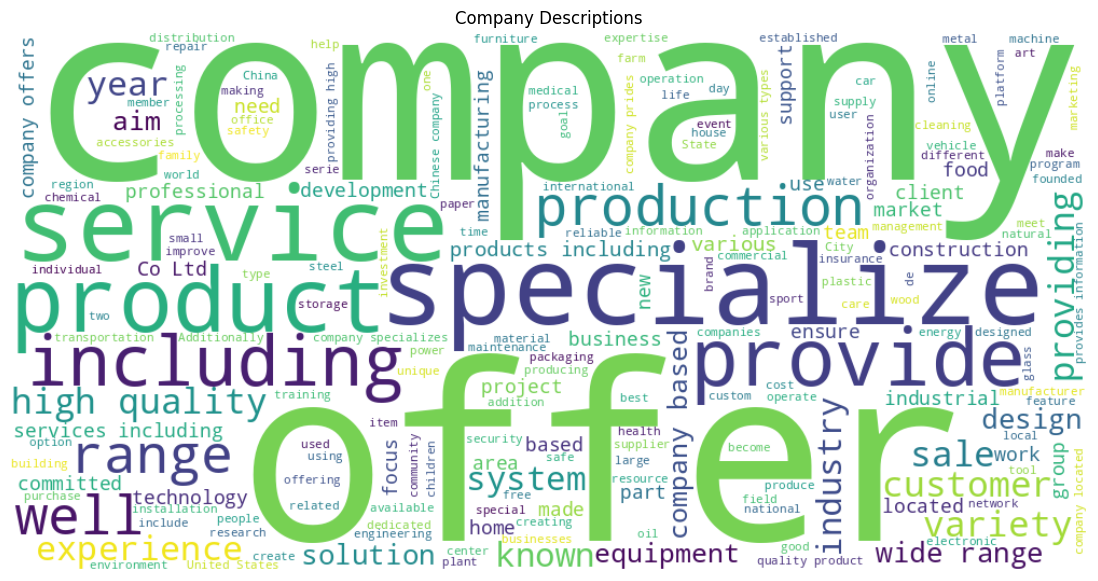

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load output
companies = pd.read_excel("companies_with_final_labels.xlsx")

# Sample view
companies[['description', 'insurance_label']].head()

# Generate wordcloud to see most common words
text_corpus = ' '.join(companies['description'].dropna().astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Company Descriptions")
plt.show()
